In [1]:
!pip install transformer_lens plotly circuitsvis

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: flatbuffers 1.12.1-git20200711.33e2d80-dfsg1-0.6 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of flatbuffers or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
from transformer_lens import HookedTransformer
from datasets import load_dataset, DatasetDict
import torch
from torch import tensor, empty, randperm, inference_mode, no_grad, Tensor
from torch.nn import Module, Linear, ReLU, Parameter, KLDivLoss
from torch.nn.functional import mse_loss, cross_entropy
from torch.optim import AdamW
from torch.utils.data import TensorDataset, DataLoader, Subset
import numpy as np
from dataclasses import dataclass
from more_itertools import pairwise, chunked
from statistics import mean
from functools import partial
from os.path import isfile
from os import makedirs
import pickle
from copy import deepcopy
from plotly.graph_objects import Figure, Scatter, Layout
import circuitsvis
from tqdm import tqdm
from typing import Dict, Optional, List

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("using", device, "device")

using cuda device


In [4]:
def run_or_load(filename, function):
    if isfile(filename):
        print(f"Loading from file {filename}.")
        with open(filename, "rb") as f:
            return pickle.load(f)

    result = function()
    with open(filename, "wb") as f:
        pickle.dump(result, f)
    return result

def tokenize_dataset(dataset, tokenizer, ncontext, tqdm_desc="tokenizing dataset") -> TensorDataset:
    if isinstance(dataset, (DatasetDict, Dict)):
        return { split_name: tokenize_dataset(split, tokenizer=tokenizer, ncontext=ncontext, tqdm_desc=f"tokenizing {split_name} dataset")
                 for split_name, split in dataset.items() }
    
    all_tokens = [tokenizer.eos_token_id]
    for story in tqdm(dataset, desc=tqdm_desc):
        tokens = tokenizer(story["text"])["input_ids"]
        all_tokens += tokens
        all_tokens += [tokenizer.eos_token_id]

    all_tokens += [tokenizer.eos_token_id] * ((-len(all_tokens)) % ncontext)
    assert len(all_tokens) % ncontext == 0

    print("putting tokens into tensor...")
    all_tokens = tensor(all_tokens)
    all_tokens = all_tokens.reshape(all_tokens.numel() // ncontext, ncontext)
    print("done")

    return TensorDataset(all_tokens)

In [5]:
model = HookedTransformer.from_pretrained("roneneldan/TinyStories-1m").to(device)

/usr/lib/python3/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Loaded pretrained model roneneldan/TinyStories-1m into HookedTransformer
Moving model to device:  cuda


In [6]:
dataset = load_dataset("roneneldan/TinyStories")
dataset = { **dataset["train"].train_test_split(test_size=0.1),
            "validation": dataset["validation"] }

dataset = run_or_load( "tokenized-dataset.pickle",
                       lambda: tokenize_dataset(dataset, tokenizer=model.tokenizer, ncontext=32) )

train_tokens_dataloader      = DataLoader(dataset["train"],      batch_size=128, shuffle=True)
test_tokens_dataloader       = DataLoader(dataset["test"],       batch_size=128)
validation_tokens_dataloader = DataLoader(dataset["validation"], batch_size=128)

Repo card metadata block was not found. Setting CardData to empty.
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Loading from file tokenized-dataset.pickle.


In [7]:
class SparseAutoencoder(Module):
    def __init__(self, d, d_hidden, activation_function=ReLU()):
        super().__init__()
        self.up = Linear(d, d_hidden)
        self.activation_function = activation_function
        self.down = Linear(d_hidden, d)
        self.hidden = None

    def forward(self, x, hook=None, return_hidden=False, save_hidden=False):
        hidden = self.up(x)
        hidden = self.activation_function(hidden)
        reconstructed = self.down(hidden)
        
        if save_hidden:
            self.hidden = hidden
        else:
            self.hidden = None

        if return_hidden:
            return reconstructed, hidden
        else:
            return reconstructed
        
@inference_mode()
def collect_activations(model: HookedTransformer, tokens_dataloader: DataLoader, checkpoint: str, num_activations: Optional[int] = None) -> Tensor:
    max_num_activations = sum(tokens.size(0) * tokens.size(1) for tokens, in tqdm(tokens_dataloader, desc="calculating number of activations"))
    if num_activations is None:
        num_activations = max_num_activations
    else:
        assert num_activations <= max_num_activations

    activations = empty(num_activations, model.cfg.d_model, device="cpu")
    i_activations = 0
    with tqdm(total=num_activations, desc="collecting activations") as progress_bar:
        for tokens, in tokens_dataloader:
            _, cache = model.run_with_cache(tokens)
            new_activations = cache[checkpoint].detach()
            new_activations = new_activations.flatten(end_dim=-2)
            num_new_activations = new_activations.size(0)
            if i_activations + num_new_activations > num_activations:
                num_new_activations = num_activations - i_activations
                new_activations = new_activations[:num_new_activations, ...]
            activations[i_activations : i_activations + num_new_activations] = new_activations.to("cpu").detach()
            i_activations += num_new_activations
            progress_bar.update(num_new_activations)
            if i_activations == num_activations:
                break
        assert i_activations == num_activations

    return activations

def smoothen(xs, smoothness=100):
    return [mean(chunk) for chunk in chunked(xs, smoothness)]

def plot_multiple_losses(loss_histories: Dict[str, List[float]], title: str, smoothness: int = 100):
    fig = Figure(layout=Layout( title=title,
                                xaxis=dict(title="Iteration") ))
    
    for i, (loss_name, loss_history) in enumerate(loss_histories.items()):
        loss_history = smoothen(loss_history, smoothness)
        fig.add_trace(Scatter( x     = list(range(0, smoothness*len(loss_history), smoothness)),
                               y     = loss_history,
                               name  = loss_name,
                               yaxis = f"y{i+1}" if i > 0 else "y" ) )

        plot_type = "log" if all(x > 0 for x in loss_history) else "linear"
        
        if i == 0:
            fig.update_layout(yaxis=dict(title=loss_name, type=plot_type))
        else:
            fig.update_layout(**{f"yaxis{i+1}": dict(title=loss_name, type=plot_type, overlaying="y", anchor="free", autoshift=True)})

    fig.show()

def train_sparse_autoencoder_standard( sparse_autoencoder: SparseAutoencoder,
                                       activations: Tensor,
                                       sparsity_penalty_coefficient: float,
                                       lr: float,
                                       epochs: int,
                                       batch_size: int,
                                       checkpoint: str, # only used for the plot title
                                       plot: bool = True ):
    sparse_autoencoder.train()
    optimizer = AdamW(sparse_autoencoder.parameters(), lr=lr)

    reconstruction_loss_history = []
    sparsity_penalty_history = []
    big_tqdm = epochs >= 20
    for epoch in tqdm(range(epochs)) if big_tqdm else range(epochs):
        # we don't use a dataloader because it's slow, so we reimplement what it does
        if not big_tqdm:
            print("shuffling activations...")
        activations = activations[randperm(activations.size(0)), :]
        if not big_tqdm:
            print("done shuffling activations")
        batch_indices = range(0, activations.size(0), batch_size)
        batch_indices = list(pairwise(batch_indices))
        for i_batch_start, i_batch_end in batch_indices if big_tqdm else tqdm(batch_indices, desc=f"epoch {epoch+1}/{epochs}"):
            activation_batch = activations[i_batch_start:i_batch_end, :].to(device)
            reconstructed, hidden = sparse_autoencoder(activation_batch, return_hidden=True)
            reconstruction_loss = mse_loss(reconstructed, activation_batch)
            sparsity_penalty = hidden.abs().sum(dim=-1).mean()
            loss = reconstruction_loss + sparsity_penalty_coefficient * sparsity_penalty
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            reconstruction_loss_history.append(reconstruction_loss.item())
            sparsity_penalty_history.append(sparsity_penalty.item())

    if plot:
        plot_multiple_losses(
            { "autoencoder reconstruction loss": reconstruction_loss_history,
              "sparsity penalty": sparsity_penalty_history },
            title=f"Training sparse autoencoder on {checkpoint} the standard way. {sparsity_penalty_coefficient=}",
            smoothness=10_000
        )

def logit_kl_div(xs, ys):
    xs = xs.log_softmax(-1)
    ys = ys.log_softmax(-1)
    return KLDivLoss(reduction="batchmean", log_target=True)(xs.flatten(end_dim=-2), ys.flatten(end_dim=-2))

def neighboring_layer_parameters(model: HookedTransformer, checkpoint: str) -> List[Parameter]:
    blocks, layer, checkpoint_within_block = checkpoint.split(".")
    assert blocks == "blocks"
    layer = int(layer)
    assert checkpoint_within_block in ["hook_resid_pre", "hook_resid_mid", "hook_resid_post", "hook_attn_out", "hook_mlp_out"]

    if checkpoint_within_block == "hook_resid_pre":
        if layer == 0:
            return list(model.embed.parameters()) + list(model.blocks[layer].attn.parameters())
        return list(model.blocks[layer-1].mlp.parameters()) + list(model.blocks[layer].attn.parameters())
    elif checkpoint_within_block in ["hook_resid_mid", "hook_attn_out"]:
        return list(model.blocks[layer].attn.parameters()) + list(model.blocks[layer].mlp.parameters())
    elif checkpoint_within_block in ["hook_resid_post", "hook_mlp_out"]:
        if layer == model.cfg.n_layers-1:
            return list(model.blocks[layer].mlp.parameters()) + list(model.unembed.parameters())
        return list(model.blocks[layer].mlp.parameters()) + list(model.blocks[layer+1].mlp.parameters())
    else:
        assert False

def train_sparse_autoncoder_with_whole_model_loss( model: HookedTransformer,
                                                   reference_model: Optional[HookedTransformer],
                                                   token_dataloader: DataLoader,
                                                   sparse_autoencoder: SparseAutoencoder,
                                                   checkpoint: str,
                                                   epochs: int,
                                                   lr: float,
                                                   sparsity_penalty_coefficient: float,
                                                   reconstruction_target: bool = True,
                                                   intrusive: bool = False,
                                                   train_neighboring_layers: bool = False,
                                                   plot: bool = True ):
    
    if not train_neighboring_layers:
        assert reference_model is None
        reference_model = model

    parameters = list(sparse_autoencoder.parameters())
    if train_neighboring_layers:
        parameters += neighboring_layer_parameters(model, checkpoint)
    optimizer = AdamW(parameters, lr=lr)
    
    sparsity_penalty_history = []
    whole_model_loss_with_autoencoder_history = []
    if not intrusive and train_neighboring_layers:
        whole_model_loss_without_autoencoder_history = []
    for epoch in range(epochs):
        for tokens, in tqdm(token_dataloader, desc=f"epoch {epoch+1}/{epochs}"):
            tokens = tokens.to(device)
            input = tokens[..., :-1]

            if reconstruction_target:
                with no_grad():
                    reference_prediction = reference_model(input).detach()
                def whole_model_loss(prediction):
                    return logit_kl_div(prediction, reference_prediction)
            else:
                output = tokens[..., 1:]
                def whole_model_loss(prediction):
                    return transformer_cross_entropy(prediction, output)

            whole_model_loss_with_autoencoder = whole_model_loss(model.run_with_hooks(
                input,
                fwd_hooks=[(checkpoint, partial(sparse_autoencoder, save_hidden=True))]
            ))
            whole_model_loss_with_autoencoder_history.append(whole_model_loss_with_autoencoder.item())
            sparsity_penalty = sparse_autoencoder.hidden.abs().sum(-1).mean()
            sparsity_penalty_history.append(sparsity_penalty.item())
            loss = whole_model_loss_with_autoencoder + sparsity_penalty_coefficient * sparsity_penalty
            if not intrusive and train_neighboring_layers:
                whole_model_loss_without_autoencoder = whole_model_loss(model(input))
                loss += whole_model_loss_without_autoencoder
                whole_model_loss_without_autoencoder_history.append(whole_model_loss_without_autoencoder.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    if plot:
        reconstruction_or_prediction = 'reconstruciton' if reconstruction_target else 'prediction'
        loss_histories = { f"whole model {reconstruction_or_prediction} loss with autoencoder": whole_model_loss_with_autoencoder_history,
                           "sparsity_penalty": sparsity_penalty_history }
        if not intrusive and train_neighboring_layers:
            loss_histories[f"whole model {reconstruction_or_prediction} loss without autoencoder"] = whole_model_loss_without_autoencoder_history
        plot_multiple_losses(
            loss_histories,
            title = f"Training {'intrusive' if intrusive else 'non intrusive'} sparse autoencoder"
                    f" {'and neighboring layers' if train_neighboring_layers else 'but not the neighboring layers'}"
                    f" on {checkpoint}"
                    f" with {'whole model reconstruction loss' if reconstruction_target else 'next token prediction loss'}."
                    f" {sparsity_penalty_coefficient=} {epochs=} {lr=}"
        )

def transformer_cross_entropy(pred: Tensor, tokens: Tensor):
    assert len(pred.shape) == len(tokens.shape) + 1
    return cross_entropy(pred.flatten(end_dim=-2), tokens.flatten())

@dataclass
class SparseAutoencoderActivations:
    tokens:      List[List[str]]    # tokens     [num_sentences][tokens_per_sentence]
    activations: List[List[Tensor]] # activations[num_sentences][tokens_per_sentence][sparse_autoencoder_d_hidden]

    def on_most_interesting_neurons(self, n):
        num_neurons = self.activations[0][0].numel()
        indices_and_interestingnesses = [
            (i, max(token_acts[i] for sentence_acts in self.activations for token_acts in sentence_acts))
            for i in range(num_neurons)
        ]
        indices_and_interestingnesses.sort(key=lambda x: x[1])
        indices = [index for index, _ in indices_and_interestingnesses]
        return SparseAutoencoderActivations(
            tokens      = self.tokens,
            activations = [[token_acts[indices] for token_acts in sentence_acts] for sentence_acts in self.activations]
        )

def sparse_autoencoder_hidden_activations( model: HookedTransformer,
                                           tokens_dataloader: DataLoader,
                                           checkpoint: str,
                                           sparse_autoencoder: SparseAutoencoder,
                                           num_sentences: int ) -> SparseAutoencoderActivations:
    
    tokens:      List[List[str]]   = [] # tokens     [num_sentences][tokens_per_sentence]
    activations: List[List[float]] = [] # activations[num_sentences][tokens_per_sentence][sparse_autoencoder_d_hidden]

    sentences: List[Tensor] = [] # num_datapoints tensors of shape 1 x tokens_per_sentence
    for batch, in tokens_dataloader:
        for sentence in batch:
            sentences.append(sentence)
            if len(sentences) >= num_sentences:
                break
        if len(sentences) >= num_sentences:
            break

    for sentence in sentences:
        tokens.append([model.tokenizer.decode(token_id) for token_id in sentence])
        model.run_with_hooks(sentence, fwd_hooks=[(checkpoint, partial(sparse_autoencoder, save_hidden=True))])
        activations.append([activations_on_token.detach().cpu() for activations_on_token in sparse_autoencoder.hidden.squeeze(0)])

    return SparseAutoencoderActivations(tokens, activations)

def visualize_sparse_autoencoder_activations(activations: SparseAutoencoderActivations):
    display(circuitsvis.activations.text_neuron_activations(
        tokens=activations.tokens,
        activations=[ np.array([ [list(activations_for_token)]
                                 for activations_for_token in activations_for_sentence ])
                      for activations_for_sentence in activations.activations ] # List[np.array["token", "layer", "neuron"]]
    ))

@inference_mode()
def test_transformer_with_sparse_autoencoder( model: HookedTransformer,
                                              token_dataloader: DataLoader,
                                              sparse_autoencoder: SparseAutoencoder,
                                              checkpoint: str ) -> float:
    losses = []
    for tokens, in tqdm(token_dataloader, desc="testing transformer with sparse autoencoder"):
        tokens = tokens.to(device)
        input = tokens[..., :-1]
        output = tokens[..., 1:]
        prediction = model.run_with_hooks(input, fwd_hooks=[(checkpoint, sparse_autoencoder)])
        loss = transformer_cross_entropy(prediction, output)
        losses.append(loss.item())
    return mean(losses)

@inference_mode()
def test_transformer_with_sparse_autoencoder_reconstruction( model: HookedTransformer,
                                                             reference_model: HookedTransformer,
                                                             token_dataloader: DataLoader,
                                                             sparse_autoencoder: SparseAutoencoder,
                                                             checkpoint: str ) -> float:
    losses = []
    for tokens, in tqdm(token_dataloader, desc="testing reconstruction of the whole model output with a sparse autoencoder"):
        tokens = tokens.to(device)
        input = tokens[..., :-1]
        reference_prediction = reference_model(input)
        prediction = model.run_with_hooks(input, fwd_hooks=[(checkpoint, sparse_autoencoder)])
        loss = logit_kl_div(prediction, reference_prediction)
        losses.append(loss.item())
    return mean(losses)

TRAINING SPARSE AUTOENCODERS ON blocks.0.hook_resid_mid WITH HIDDEN DIMENSION 512
COLLECTING ACTIVATIONS


collecting activations: 100%|██████████| 100000000/100000000 [08:10<00:00, 203713.61it/s]


PRETRAINING SPARSE AUTOENCODER


100%|██████████| 50/50 [22:45<00:00, 27.31s/it]


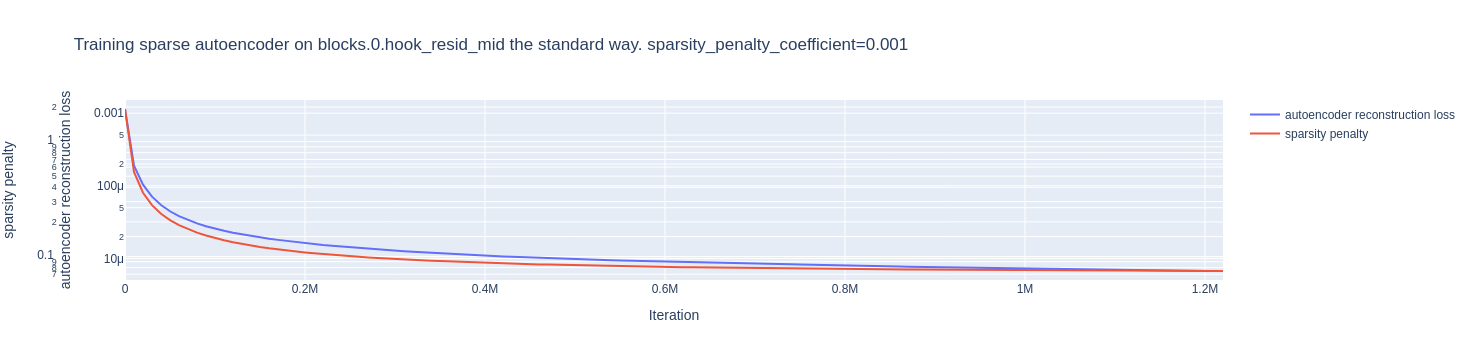

TRAINING STANDARD SPARSE AUTOENCODER


100%|██████████| 50/50 [22:50<00:00, 27.41s/it]


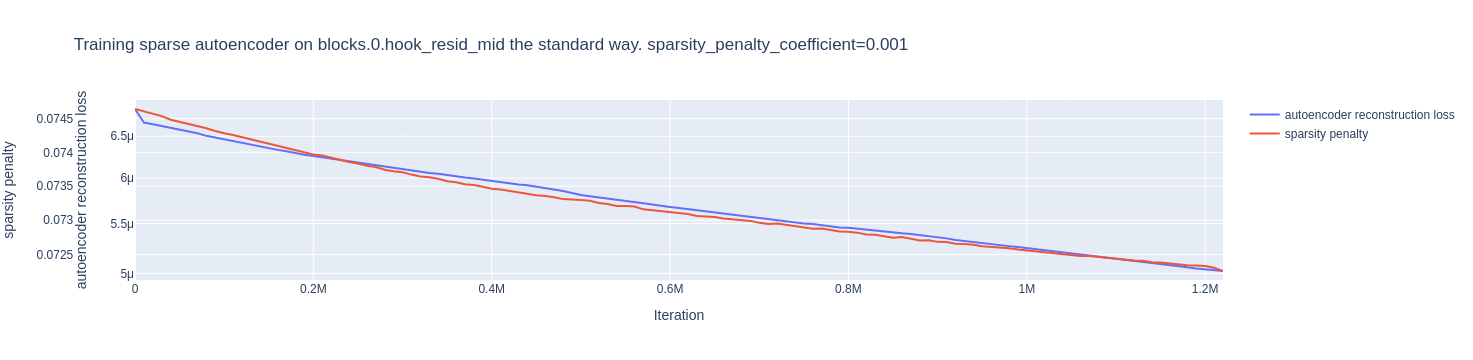

TRAINING FROZEN SPARSE AUTOENCODER


epoch 1/1: 100%|██████████| 7813/7813 [13:06<00:00,  9.93it/s]


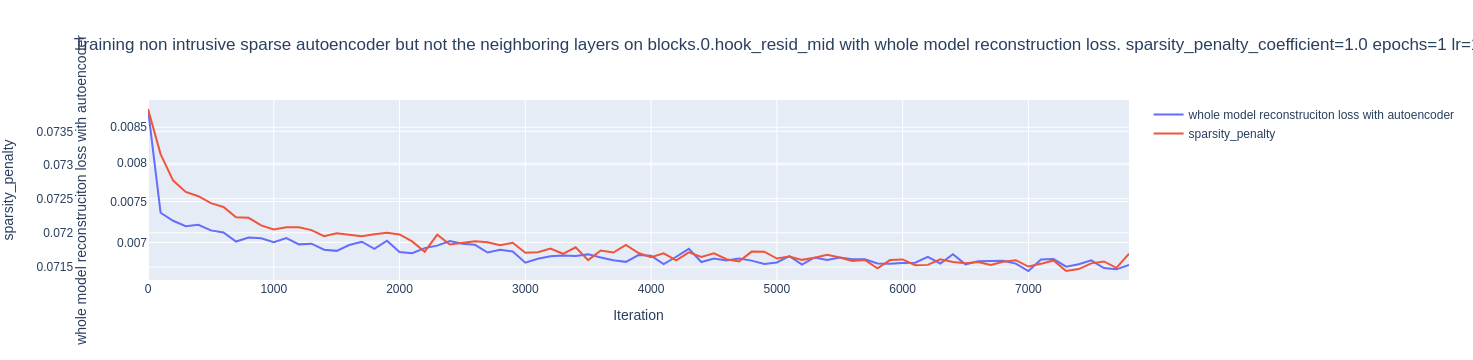

TRAINING INTRUSIVE SPARSE AUTOENCODER
Loaded pretrained model roneneldan/TinyStories-1m into HookedTransformer


epoch 1/1: 100%|██████████| 7813/7813 [13:11<00:00,  9.87it/s]


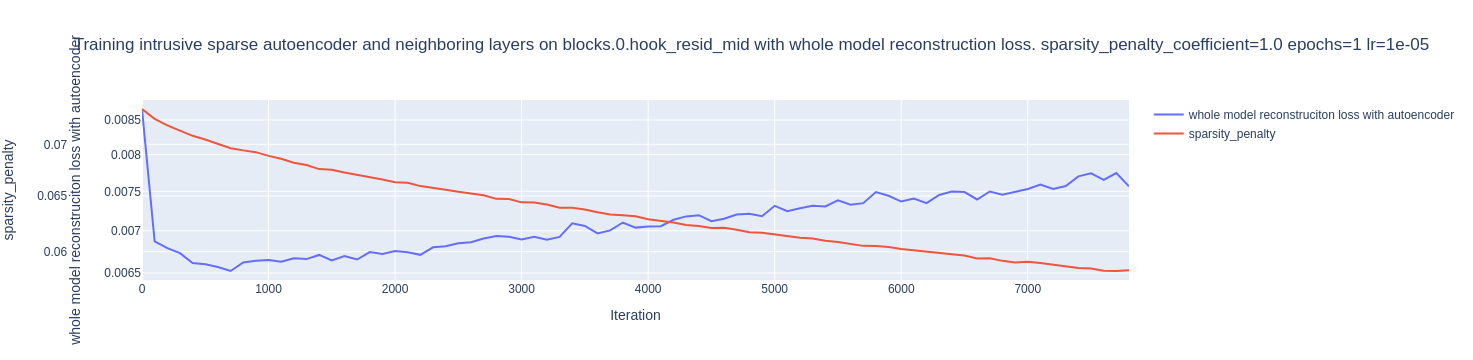

TRAINING NON INTRUSIVE SPARSE AUTOENCODER
Loaded pretrained model roneneldan/TinyStories-1m into HookedTransformer


epoch 1/1: 100%|██████████| 7813/7813 [24:28<00:00,  5.32it/s]


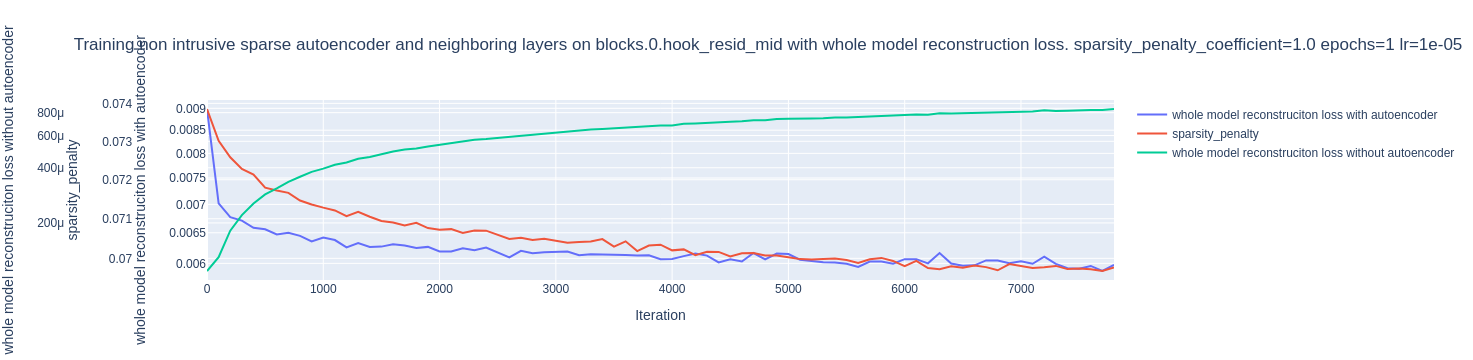

TRAINING SPARSE AUTOENCODERS ON blocks.1.hook_resid_pre WITH HIDDEN DIMENSION 512
COLLECTING ACTIVATIONS


collecting activations: 100%|██████████| 100000000/100000000 [08:16<00:00, 201273.07it/s]


PRETRAINING SPARSE AUTOENCODER


100%|██████████| 50/50 [23:07<00:00, 27.75s/it]


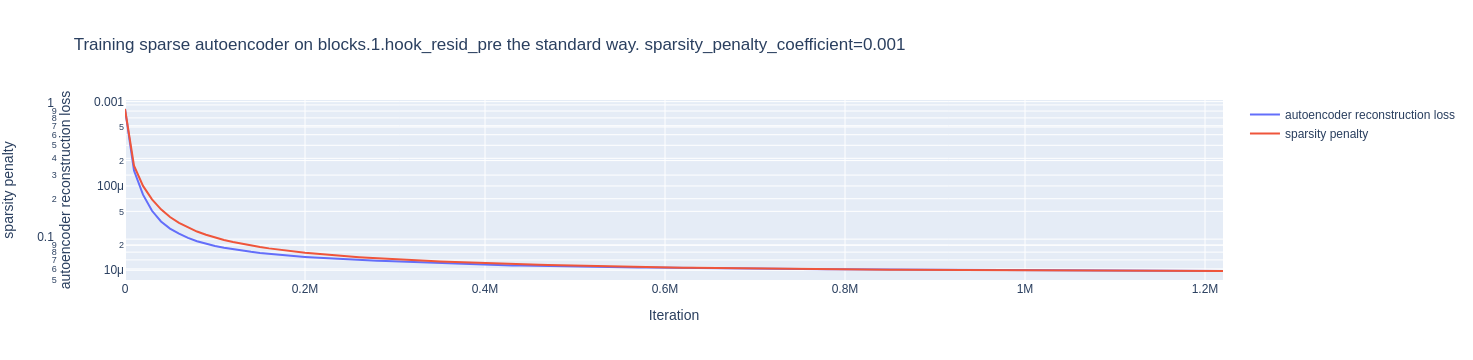

TRAINING STANDARD SPARSE AUTOENCODER


100%|██████████| 50/50 [22:53<00:00, 27.48s/it]


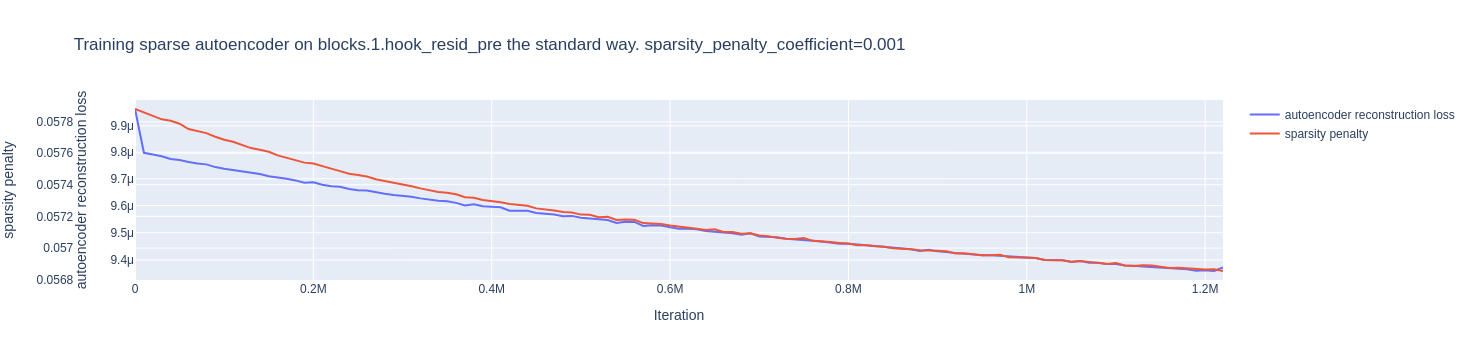

TRAINING FROZEN SPARSE AUTOENCODER


epoch 1/1: 100%|██████████| 7813/7813 [13:04<00:00,  9.95it/s]


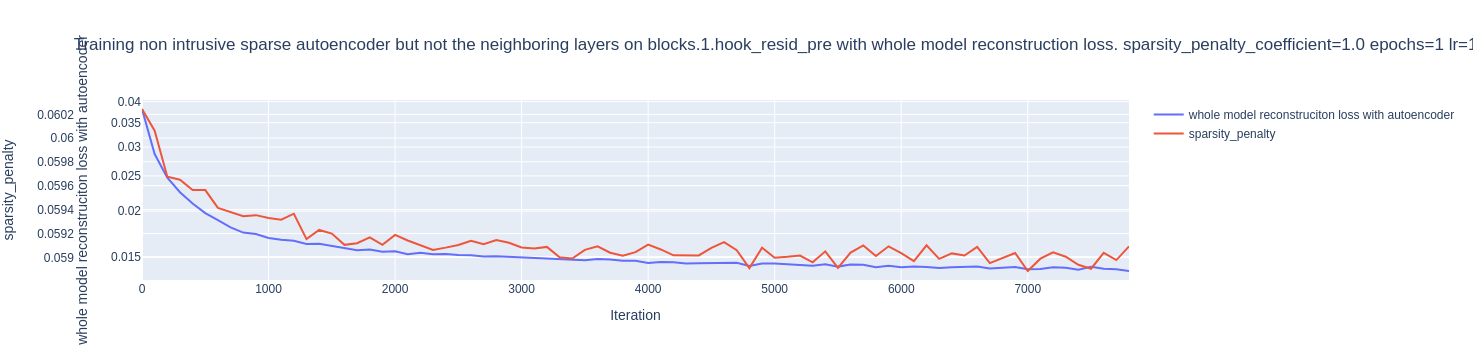

TRAINING INTRUSIVE SPARSE AUTOENCODER
Loaded pretrained model roneneldan/TinyStories-1m into HookedTransformer


epoch 1/1: 100%|██████████| 7813/7813 [13:07<00:00,  9.92it/s]


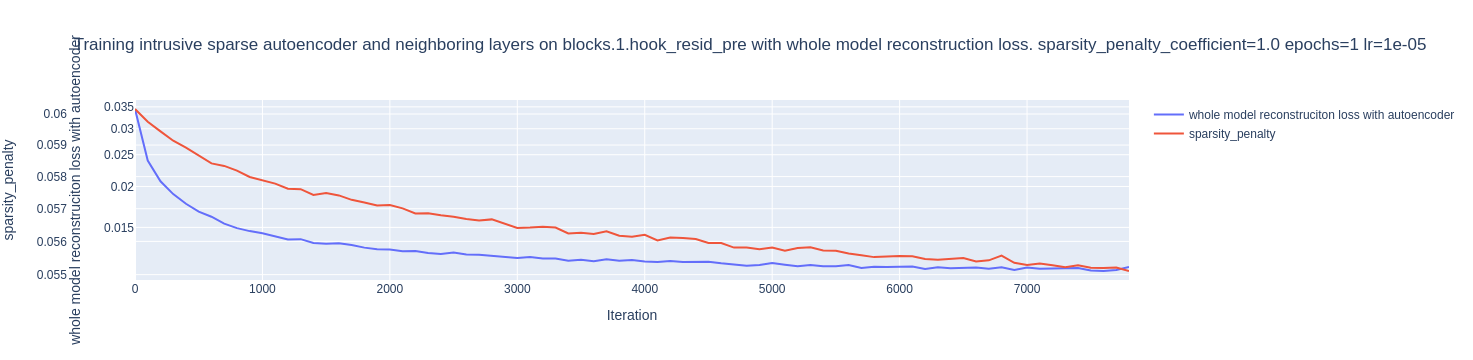

TRAINING NON INTRUSIVE SPARSE AUTOENCODER
Loaded pretrained model roneneldan/TinyStories-1m into HookedTransformer


epoch 1/1: 100%|██████████| 7813/7813 [24:30<00:00,  5.31it/s]


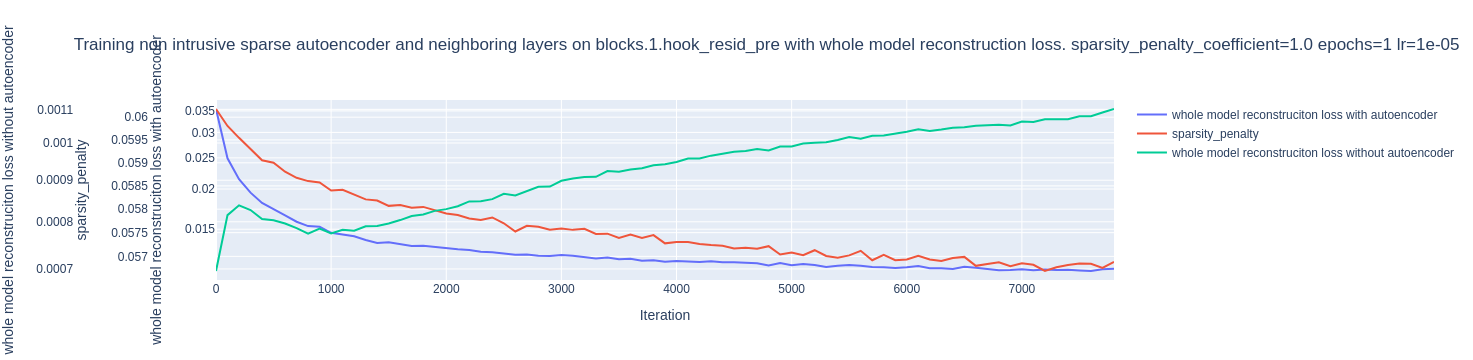

TRAINING SPARSE AUTOENCODERS ON blocks.3.hook_resid_post WITH HIDDEN DIMENSION 512
COLLECTING ACTIVATIONS


collecting activations: 100%|██████████| 100000000/100000000 [08:18<00:00, 200628.93it/s]


PRETRAINING SPARSE AUTOENCODER


100%|██████████| 50/50 [23:12<00:00, 27.86s/it]


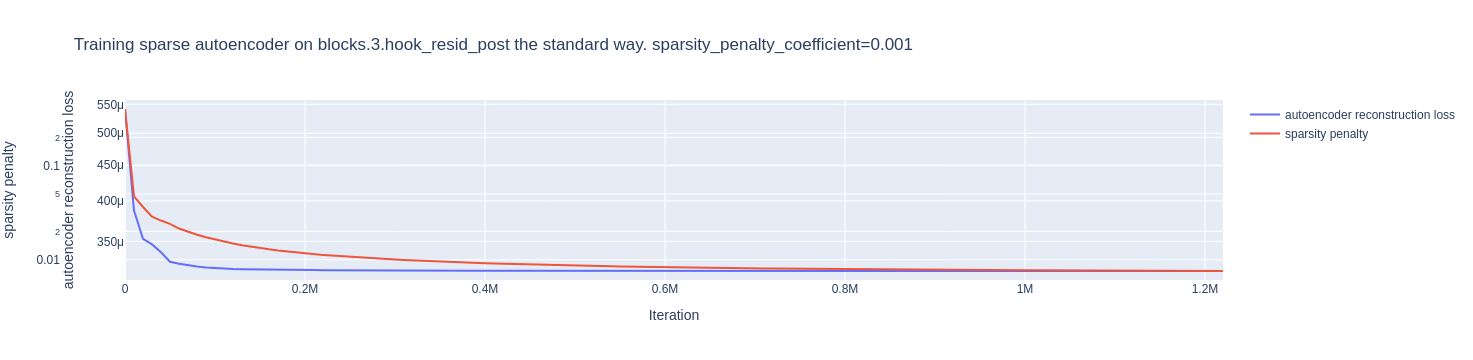

TRAINING STANDARD SPARSE AUTOENCODER


100%|██████████| 50/50 [22:51<00:00, 27.43s/it]


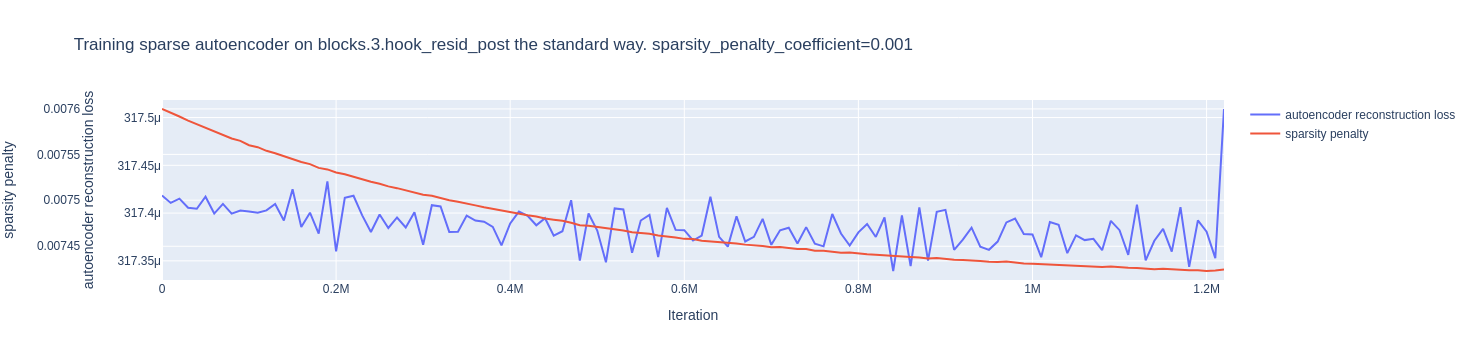

TRAINING FROZEN SPARSE AUTOENCODER


epoch 1/1:   6%|▌         | 448/7813 [00:45<12:26,  9.86it/s]

In [ ]:
checkpoints_and_d_hiddens = [ ("blocks.0.hook_resid_mid",   8 * model.cfg.d_model),
                              ("blocks.1.hook_resid_pre",   8 * model.cfg.d_model),
                              ("blocks.3.hook_resid_post",  8 * model.cfg.d_model) ]

for checkpoint, d_hidden in checkpoints_and_d_hiddens:
    print(f"TRAINING SPARSE AUTOENCODERS ON {checkpoint} WITH HIDDEN DIMENSION {d_hidden}")
    
    save_directory = f"sparse-autoencoder-{checkpoint}-d-hidden-{d_hidden}"
    makedirs(save_directory, exist_ok=True)

    print("COLLECTING ACTIVATIONS")
    train_activations = collect_activations(model, train_tokens_dataloader, num_activations=100_000_000, checkpoint=checkpoint)
    
    print("PRETRAINING SPARSE AUTOENCODER")
    pretrained_sparse_autoencoder = SparseAutoencoder(model.cfg.d_model, d_hidden).to(device)
    train_sparse_autoencoder_standard(
        pretrained_sparse_autoencoder,
        train_activations,
        sparsity_penalty_coefficient=1e-3,
        lr=1e-4,
        epochs=50,
        batch_size=4096,
        checkpoint=checkpoint
    )
    with open(f"{save_directory}/pretrained.pickle", "wb") as f:
        pickle.dump(pretrained_sparse_autoencoder.state_dict(), f)

    print("TRAINING STANDARD SPARSE AUTOENCODER")
    standard_sparse_autoencoder = SparseAutoencoder(model.cfg.d_model, d_hidden).to(device)
    standard_sparse_autoencoder.load_state_dict(pretrained_sparse_autoencoder.state_dict())
    train_sparse_autoencoder_standard(
        standard_sparse_autoencoder,
        train_activations,
        sparsity_penalty_coefficient=1e-3,
        lr=1e-4,
        epochs=50,
        batch_size=4096,
        checkpoint=checkpoint
    )
    with open(f"{save_directory}/standard.pickle", "wb") as f:
        pickle.dump(standard_sparse_autoencoder.state_dict(), f)

    print("TRAINING FROZEN SPARSE AUTOENCODER")
    frozen_sparse_autoencoder = SparseAutoencoder(model.cfg.d_model, d_hidden).to(device)
    frozen_sparse_autoencoder.load_state_dict(pretrained_sparse_autoencoder.state_dict())
    train_sparse_autoncoder_with_whole_model_loss(
        model=model,
        reference_model=None,
        token_dataloader=DataLoader(Subset(dataset["train"], range(1_000_000)), shuffle=True, batch_size=128),
        sparse_autoencoder=frozen_sparse_autoencoder,
        checkpoint=checkpoint,
        epochs=1,
        lr=1e-5,
        sparsity_penalty_coefficient=1.,
        intrusive=False,
        reconstruction_target=True,
        train_neighboring_layers=False
    )
    with open(f"{save_directory}/frozen.pickle", "wb") as f:
        pickle.dump(frozen_sparse_autoencoder.state_dict(), f)
    
    print("TRAINING INTRUSIVE SPARSE AUTOENCODER")
    intrusive_sparse_autoencoder = SparseAutoencoder(model.cfg.d_model, d_hidden).to(device)
    intrusive_sparse_autoencoder.load_state_dict(pretrained_sparse_autoencoder.state_dict())
    model_for_intrusive = HookedTransformer.from_pretrained("roneneldan/TinyStories-1m")
    train_sparse_autoncoder_with_whole_model_loss(
        model=model_for_intrusive,
        reference_model=model,
        token_dataloader=DataLoader(Subset(dataset["train"], range(1_000_000)), shuffle=True, batch_size=128),
        sparse_autoencoder=intrusive_sparse_autoencoder,
        checkpoint=checkpoint,
        epochs=1,
        lr=1e-5,
        sparsity_penalty_coefficient=1.,
        intrusive=True,
        reconstruction_target=True,
        train_neighboring_layers=True
    )
    with open(f"{save_directory}/intrusive.pickle", "wb") as f:
        pickle.dump(intrusive_sparse_autoencoder.state_dict(), f)
    with open(f"{save_directory}/model-for-intrusive.pickle", "wb") as f:
        pickle.dump(model_for_intrusive.state_dict(), f)

    print("TRAINING NON INTRUSIVE SPARSE AUTOENCODER")
    non_intrusive_sparse_autoencoder = SparseAutoencoder(model.cfg.d_model, d_hidden).to(device)
    non_intrusive_sparse_autoencoder.load_state_dict(pretrained_sparse_autoencoder.state_dict())
    model_for_non_intrusive = HookedTransformer.from_pretrained("roneneldan/TinyStories-1m")
    train_sparse_autoncoder_with_whole_model_loss(
        model=model_for_non_intrusive,
        reference_model=model,
        token_dataloader=DataLoader(Subset(dataset["train"], range(1_000_000)), shuffle=True, batch_size=128),
        sparse_autoencoder=non_intrusive_sparse_autoencoder,
        checkpoint=checkpoint,
        epochs=1,
        lr=1e-5,
        sparsity_penalty_coefficient=1.,
        intrusive=False,
        reconstruction_target=True,
        train_neighboring_layers=True
    )
    with open(f"{save_directory}/non-intrusive.pickle", "wb") as f:
        pickle.dump(non_intrusive_sparse_autoencoder.state_dict(), f)
    with open(f"{save_directory}/model-for-non-intrusive.pickle", "wb") as f:
        pickle.dump(model_for_non_intrusive.state_dict(), f)

In [ ]:
test_losses = dict()

for checkpoint, d_hidden in checkpoints_and_d_hiddens[:1]:
    print(f"TESTING SPARSE AUTOENCODER ON {checkpoint} WITH HIDDEN DIMENSION {d_hidden}")
    save_directory = f"sparse-autoencoder-{checkpoint}-d-hidden-{d_hidden}"
    for autoencoder_type, needs_model in [("standard", False), ("frozen", False), ("intrusive", True), ("non-intrusive", True)]:
        sparse_autoencoder = SparseAutoencoder(model.cfg.d_model, d_hidden).to(device)
        with open(f"{save_directory}/{autoencoder_type}.pickle", "rb") as f:
            sparse_autoencoder.load_state_dict(pickle.load(f))
        model_for_autoencoder = HookedTransformer.from_pretrained("roneneldan/TinyStories-1m").to(device)
        if needs_model:
            with open(f"{save_directory}/model-for-{autoencoder_type}.pickle", "rb") as f:
                model_for_autoencoder.load_state_dict(pickle.load(f))

        test_loss = test_transformer_with_sparse_autoencoder_reconstruction( reference_model=model,
                                                                             model=model_for_autoencoder,
                                                                             token_dataloader=test_tokens_dataloader,
                                                                             sparse_autoencoder=sparse_autoencoder,
                                                                             checkpoint=checkpoint )
        print(f"Test loss for {autoencoder_type} sparse autoencoder on {checkpoint} with hidden dimension {d_hidden}: {test_loss}")
        test_losses[(checkpoint, d_hidden, autoencoder_type)] = test_loss
        with open("test-losses.pickle", "wb") as f:
            pickle.dump(test_losses, f)